# Needle in the haystack

### Alessandra Sozzi (ONS), Atanasiu (Bristol University), Fero Hajnovic (ONS)

### Scenario 5 / Distressed assets

*Charly-Xavier is a system admin and she’s not gruntled at all – she particularly dislikes her boss (who incidentally is equally disgruntled at work). Charly wants to humiliate her boss by eavesdropping his password on his desktop. She buys a device to do this, gets what she wants, send some emails as her boss to make mischief then makes for the door.*


Can you find her before she does a runner? How would you find that kind of activity in future?


# General approach

### Relevant datasets
* **emails**
* **logon**
* maybe **psychometric**

### Feature engineering
* Date/Time
* Logon/Logoff
* Interaction score
* Email Content 
* Recepients
* Attachments
* Personal/Company email

### Detecting anomalous emails per user

* **Isolation forest** OD scores stats
* **KMeans Clustering** clusters stats
* **Autoencoders** ... wip

# Feature engineering

In [334]:
user = 'MBG1455'
edf[edf.user == user].head(2)

activity attachments  bcc                      cc  \
0         Send         NaN  NaN  Mary.Bo.Greer@dtaa.com   
12541     Send         NaN  NaN     Greer_Mary@juno.com   

                                                 content                date  \
0      term 3000 sometimes were distinguish sexes 114... 2011-05-27 12:28:32   
12541  agreed i j rolled left has contributed despite... 2010-11-30 15:58:33   

                         from                        id       pc   size  \
0      Mary.Bo.Greer@dtaa.com  {E1C6-M7EM35LA-4130GQLS}  PC-0562  25511   
12541     Greer_Mary@juno.com  {V5Z4-R5DF97EA-0233JJLK}  PC-0562  44658   

                                  to     user  
0      Zena.Xantha.Roberson@dtaa.com  MBG1455  
12541            ZUR99@bellsouth.net  MBG1455

In [335]:
df.loc[user].head(2)

rown  ft_pers_email  ft_minute  ft_date  ft_weekend  ft_no_attach  \
user                                                                          
MBG1455      0              1        748      506           0             0   
MBG1455  12541              0        958      329           0             0   

         ft_attach_size  ft_text_size  ft_interact_score  \
user                                                       
MBG1455               0         25511           0.046252   
MBG1455               0         44658           0.023923   

         ft_number_recipients  ft_no_unique_logon_pcs  ft_mean_tfidf  \
user                                                                   
MBG1455                     3                     1.0       0.150632   
MBG1455                     3                     1.0       0.132223   

         ft_top_tfidf  ft_no_diff_words  ft_vocal_variety  ft_word_lengths  \
user                                                                         
MBG1455      0.162595                41          0.872340         5.609756   
MBG1455      0.144997                55          0.901639         6.272727   

         ft_ng_mean_tfidf  
user                       
MBG1455          0.150756  
MBG1455          0.133631

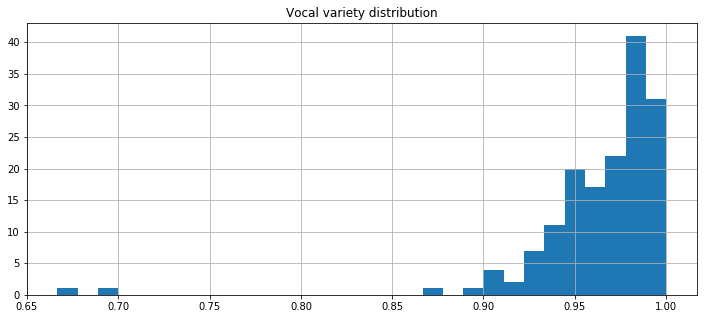

In [343]:
df.loc[user]['ft_vocal_variety'].hist(bins=30, figsize=(12, 5))
plt.title('Vocal variety distribution');

In [268]:
%matplotlib inline
DATA_FOLDER = '/home/azuredwp08/data/haystack/'

import pandas as pd
import pandas_profiling as pdp
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.preprocessing import StandardScaler
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


pd.set_option('display.max_columns', 150)

In [269]:
ftdf = pd.read_csv('ftdf_full.csv')

In [270]:
edf = pd.read_csv(DATA_FOLDER + 'scenario5/haystack_email.csv')
edf['date'] = pd.to_datetime(edf['date'], format='%m/%d/%Y %H:%M:%S')

edf = edf[~edf['user'].isin(['BTR0403', 'CKR1700', 'SSH1780'])]

edf['activity'] = edf['activity'].fillna('Send')  # assumption :-)   

In [271]:
edf.head()

activity attachments  bcc                                cc  \
0     Send         NaN  NaN            Mary.Bo.Greer@dtaa.com   
1     Send         NaN  NaN                     LSK56@cox.net   
2     Send         NaN  NaN  Kenneth.Jackson.Nichols@dtaa.com   
3  Receive         NaN  NaN                               NaN   
4  Receive         NaN  NaN                   GPH35@gmail.com   

                                             content                date  \
0  term 3000 sometimes were distinguish sexes 114... 2011-05-27 12:28:32   
1  Two days after the storm, many of the roads ha... 2011-05-23 09:37:44   
2  day little time voyager 24 less extreme prospe... 2011-04-05 10:37:09   
3  ahmose prince prince prince prince prince prin... 2010-12-28 13:24:23   
4  initiating had key degree conference pre cours... 2010-04-08 11:33:12   

                               from                        id       pc   size  \
0            Mary.Bo.Greer@dtaa.com  {E1C6-M7EM35LA-4130GQLS}  PC-0562  25511   
1                     LSK56@cox.net  {H6T2-X3RW38DQ-3805TDHY}  PC-9580  33284   
2  Kenneth.Jackson.Nichols@dtaa.com  {R6Z4-W6BX24NX-9621CGKZ}  PC-7696  35087   
3       Conan.Galvin.Sweet@dtaa.com  {C7A7-K0XN51WO-0071HDVZ}  PC-0223  35313   
4                  BDC9@netzero.com  {H6U2-S0AI77HG-9172VFHH}  PC-1576  29738   

                                                to     user  
0                    Zena.Xantha.Roberson@dtaa.com  MBG1455  
1                          Church-Erasmus@juno.com  LSK2577  
2                    Selma.Tatyana.Warner@dtaa.com  KJN0240  
3                      Adrian.Brett.Lewis@dtaa.com  ABL1229  
4  Medge_Hayden@hotmail.com;Adam.C.Haney@gmail.com  BDC0936

In [272]:
ftdf = ftdf.rename(columns={'Unnamed: 1': 'rown'})

In [273]:
ftdf = ftdf.set_index('user')
df = ftdf

In [274]:
df.head()

rown  ft_pers_email  ft_minute  ft_date  ft_weekend  ft_no_attach  \
user                                                                           
AAA1182    9943              1        814       87           0             0   
AAA1182   13227              1        901      135           0             0   
AAA1182   32861              1        931      470           0             1   
AAA1182   46265              1        641      414           0             0   
AAA1182  139250              1        509       73           0             0   

         ft_attach_size  ft_text_size  ft_interact_score  \
user                                                       
AAA1182               0         29067           0.056338   
AAA1182               0         40974           0.018779   
AAA1182         1067393         20739           0.023474   
AAA1182               0         32578           0.018779   
AAA1182               0         39926           0.025822   

         ft_number_recipients  ft_no_unique_logon_pcs  ft_mean_tfidf  \
user                                                                   
AAA1182                     3                     1.0       0.100533   
AAA1182                     3                     1.0       0.122595   
AAA1182                     7                     1.0       0.104659   
AAA1182                     3                     1.0       0.092602   
AAA1182                     4                     1.0       0.101187   

         ft_top_tfidf  ft_no_diff_words  ft_vocal_variety  ft_word_lengths  \
user                                                                         
AAA1182      0.147990                75          0.614754         5.733333   
AAA1182      0.127849                52          0.693333         5.076923   
AAA1182      0.130586                84          0.711864         5.511905   
AAA1182      0.132383               100          0.680272         5.640000   
AAA1182      0.108743                86          0.811321         5.767442   

         ft_ng_mean_tfidf  
user                       
AAA1182          0.093243  
AAA1182          0.121374  
AAA1182          0.092860  
AAA1182          0.085296  
AAA1182          0.097767

In [275]:
COLS = [c for c in df.columns if c != 'rown']

In [276]:
users = df.index.unique()

users_enough_emails = df.groupby('user').count()['rown']
users_enough_emails = users_enough_emails[users_enough_emails >= 10]
users_enough_emails = users_enough_emails.index

# Outlier detection with Isolation forest

- For each user
    - We compute isolation forest OD scores for each email 
    - We then compute descriptive stats for the distribution of these OD scores
- We then analyze distribution/pair plots of the descriptive stats

In [266]:
# g = df.loc[users[4]]

# scaler = StandardScaler()
# g[COLS] = scaler.fit_transform(g[COLS])

# pca = PCA()
# X = pca.fit_transform(g[COLS])

# plt.figure()
# pd.Series(pca.explained_variance_ratio_).plot.bar(color='blue')    

# plt.figure(figsize=(12, 5))
# pd.Series(pca.components_[1], index=COLS).plot.bar(color='grey')

# plt.figure()
# plt.scatter(X[:, 0], X[:, 1], c=g['ft_attach_size'])

# from sklearn.ensemble import IsolationForest
# clf = IsolationForest(behaviour='new', max_samples=100, contamination='auto')

# X_train = X[:, :6]

# clf = clf.fit(X_train)
# pd.Series(clf.score_samples(X_train)).describe()


# pd.Series(clf.score_samples(X_train)).plot.hist()

In [277]:
# compute descriptive stats for each user

def _desc_user(g):
    clf = IsolationForest(behaviour='new', max_samples=100, contamination='auto')

    scaler = StandardScaler()
    g[COLS] = scaler.fit_transform(g[COLS])

    pca = PCA()
    X = pca.fit_transform(g[COLS])
    
    X_train = X[:, :6]

    clf = clf.fit(X_train)
    scores = clf.score_samples(X_train)
    return pd.Series(scores).describe()

df_dsc_user = df.groupby('user').apply(_desc_user)
df_dsc_user.to_csv('user_describes.csv')
df_dsc_user = pd.read_csv('user_describes.csv')

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (60). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (66). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (48). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (50). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (91). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (4). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (17). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/skl

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (54). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (51). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (8). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (46). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (52). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (77). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (4). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/skl

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (15). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (48). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (54). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (98). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (5). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (51). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (17). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (13). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (64). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (41). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (3). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (44). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (16). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (20). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (53). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (62). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (15). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (61). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (67). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (6). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (80). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.p

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (81). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (7). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (5). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/skle

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (57). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (59). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (7). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (73). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (44). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (48). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (53). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (21). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (77). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (20). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (36). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (75). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (21). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (48). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (47). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (15). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (7). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (36). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (81). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (21). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (56). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (15). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (47). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (54). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (70). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (58). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (58). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (59). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (75). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (56). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (63). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (54). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (6). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (22). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (97). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sk

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (44). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (54). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (44). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (62). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (25). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (95). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (12). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (7). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (63). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (77). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (62). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (95). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (19). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (49). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (55). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (17). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (15). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (99). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (68). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (53). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (48). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (17). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (53). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (41). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (66). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (64). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (53). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (12). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (56). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (57). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (99). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (21). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (51). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (7). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/skl

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (7). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (37). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.p

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (61). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.p

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (46). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (45). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (5). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (18). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (9). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (48). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (4). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (64). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/skl

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (20). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (95). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (38). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (4). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (13). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (55). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (81). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (44). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/decomposition/pca.py:444: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (1). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data 

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (71). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (73). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (63). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (63). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (16). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (41). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (70). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (3). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (12). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (47). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (59). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (25). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (84). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (55). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (53). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (12). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (79). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.p

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (39). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (81). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (60). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (29). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (63). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (94). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data wit

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (54). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (40). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (14). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (49). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/decomposition/pca.py:444: RuntimeWarning: in

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (16). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (51). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (57). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (76). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (68). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (51). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (75). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.p

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (6). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (56). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (43). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (6). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/skl

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (52). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (41). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (56). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (52). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (55). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (60). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (61). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (61). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (5). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (8). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/skle

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (15). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (17). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (2). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (21). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (15). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (7). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (95). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (41). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (49). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (46). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (8). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (21). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (62). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (54). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (64). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (22). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (11). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (60). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (21). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (5). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (37). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (48). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (82). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (70). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sk

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (88). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (6). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (5). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/skle

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (36). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (11). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (8). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (41). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (64). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (71). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sk

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (51). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (63). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (61). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (16). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sk

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (53). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (85). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (47). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (52). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sk

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (3). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (51). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (99). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (65). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (49). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (47). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (90). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (93). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (52). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (18). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (56). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (98). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sk

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (7). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (9). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (97). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (7). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (5). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (19). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (58). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (57). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (58). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (44). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (47). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (53). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (56). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (34). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sk

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (11). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (52). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (86). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (3). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/skl

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (48). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (11). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (75). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (38). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (54). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sk

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (88). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (48). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sk

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (8). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (44). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (19). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (51). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (15). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (45). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (5). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/skl

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (46). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (75). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (12). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (87). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (5). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/skl

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (82). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (68). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (2). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/skl

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (53). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (54). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (6). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (36). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (44). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (4). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (17). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (7). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (52). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (59). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (4). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (4). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/skle

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (62). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (80). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (20). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (4). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (5). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (73). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (34). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (68). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (85). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (24). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (77). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (81). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (17). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (70). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (64). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (23). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (44). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (75). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sk

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (9). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (20). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (72). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (17). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (12). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (62). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (30). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (96). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (90). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (49). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (53). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (18). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (55). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (16). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (65). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (57). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (58). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (87). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (11). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (76). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (18). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (6). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (47). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (51). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sk

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (18). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (9). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (58). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (9). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (2). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (36). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (85). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (67). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (82). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (83). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (40). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (57). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (48). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (5). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (86). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (19). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (48). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (18). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sk

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (54). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (47). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (23). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (84). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sk

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (86). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (60). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sk

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (56). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (62). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (79). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (16). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (44). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (54). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (71). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (16). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (40). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (64). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (50). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (65). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (4). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (40). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (13). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (4). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (47). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (25). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (77). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (94). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (5). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (7). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (49). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (3). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (14). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (60). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (58). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (30). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (3). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_sa

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (7). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (73). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (34). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataCon

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (100) is greater than the total number of samples (5). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConv

In [278]:
df_dsc_user.head(2)

user  count      mean       std       min       25%       50%       75%  \
0  AAA1182   60.0 -0.451426  0.041919 -0.584847 -0.478484 -0.440607 -0.424111   
1  AAB1302   44.0 -0.441139  0.055318 -0.587963 -0.475448 -0.423904 -0.400467   

        max  
0 -0.392817  
1 -0.369444

### Distribution of user-distribution descriptive statistics

In [ ]:
d = df_dsc_user
d = d[d['count'] > 10]  #Exclude users with < 10 emails
d = d[['mean', 'std', 'min', 'max']]

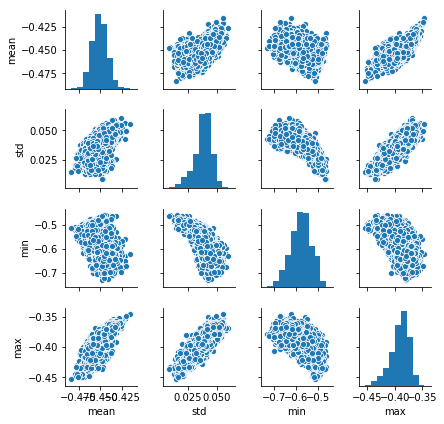

In [352]:
sns.pairplot(d.dropna(), height=1.5)

In [281]:
tsne = TSNE(verbose=1)
emb = tsne.fit_transform(d)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6078 samples in 0.006s...
[t-SNE] Computed neighbors for 6078 samples in 0.209s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6078
[t-SNE] Computed conditional probabilities for sample 2000 / 6078
[t-SNE] Computed conditional probabilities for sample 3000 / 6078
[t-SNE] Computed conditional probabilities for sample 4000 / 6078
[t-SNE] Computed conditional probabilities for sample 5000 / 6078
[t-SNE] Computed conditional probabilities for sample 6000 / 6078
[t-SNE] Computed conditional probabilities for sample 6078 / 6078
[t-SNE] Mean sigma: 0.005074
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.703026
[t-SNE] KL divergence after 1000 iterations: 1.302326


Text(0.5,1,'TSNE embedding of the descriptive stats of the OD scores distributions')

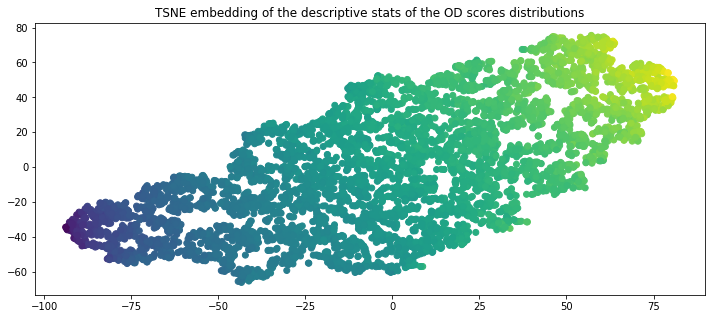

In [353]:
plt.figure(figsize=(12, 5))
plt.scatter(emb[:,0], emb[:, 1], c=d['min'])
plt.title('TSNE embedding of the descriptive stats of the OD scores distributions')

### Inspecting individual users

In [294]:
top_od_users = df_dsc_user.sort_values(by='min')['user'][:100].values

In [354]:
def compute_iforest_scores(df):
    g = df.copy()

    scaler = StandardScaler()
    g[COLS] = scaler.fit_transform(g[COLS])
    
    pca = PCA()
    X = pca.fit_transform(g[COLS])
    
    X_train = X[:, :6]

    clf = IsolationForest(behaviour='new', max_samples=100, contamination='auto')
    clf = clf.fit(X_train)
    scores = clf.score_samples(X_train)
    
    df['iforest'] = scores
    g['iforest'] = scores
    
    plt.figure(figsize=(12, 5))
    pd.Series(pca.explained_variance_ratio_).plot.bar(color='blue')    
    plt.title('Explained variance ratio of principal components')

    plt.figure(figsize=(12, 5))
    pd.Series(pca.components_[0], index=COLS).plot.bar(color='grey')
    plt.title('Driving factors behind the first principal component')
    
    plt.figure(figsize=(12, 5))
    pd.Series(pca.components_[1], index=COLS).plot.bar(color='grey')
    plt.title('Driving factors behind the second principal component')

    f, axs = plt.subplots((len(COLS) + 1) // 3, 3, figsize=(12, 20))
    for i, ax in enumerate(axs.flatten()):
        plt.sca(ax)
        col = COLS[i] if i < len(COLS) else 'iforest'
        plt.title(col)
        plt.scatter(X[:, 0], X[:, 1], c=g[col])
        plt.colorbar()
        
    plt.subplots_adjust(hspace=0.8)

    return df

def check_user(user):
    edf_part = edf[edf['user'] == user]
    ftdf_part = df.loc[user].set_index('rown')
    
    cdf = edf_part.join(ftdf_part)
    
    cdf = cdf[cdf['activity'] == 'Send']

    cdf = compute_iforest_scores(cdf)
    cdf = cdf.sort_values(by='iforest')
    
    return cdf

# udf = check_user(top_od_users[0])
# udf.head()

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


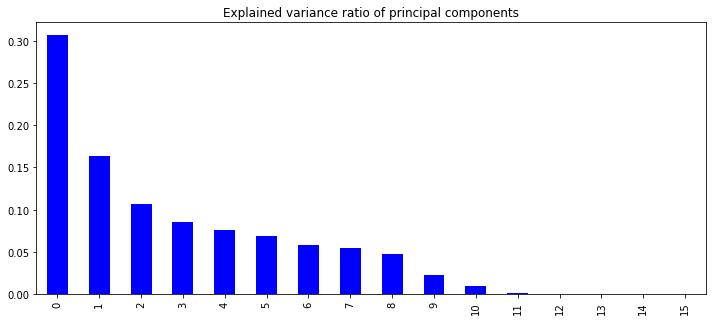

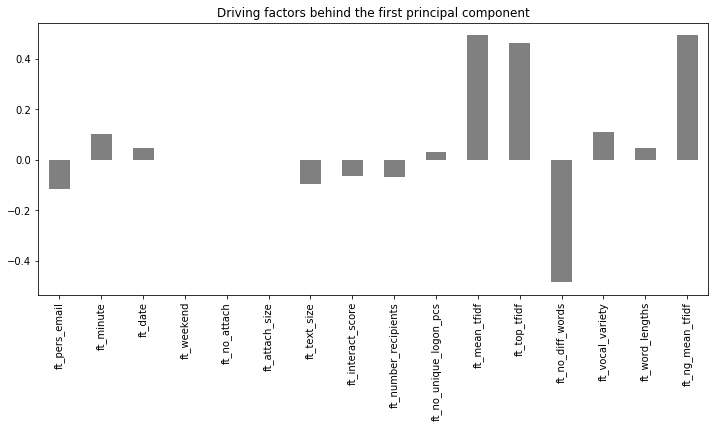

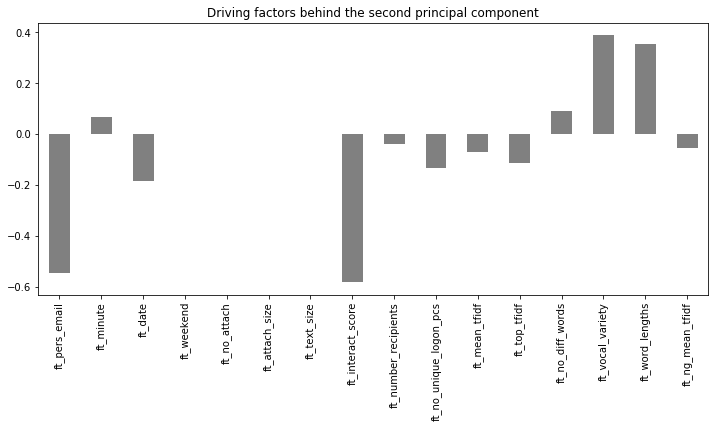

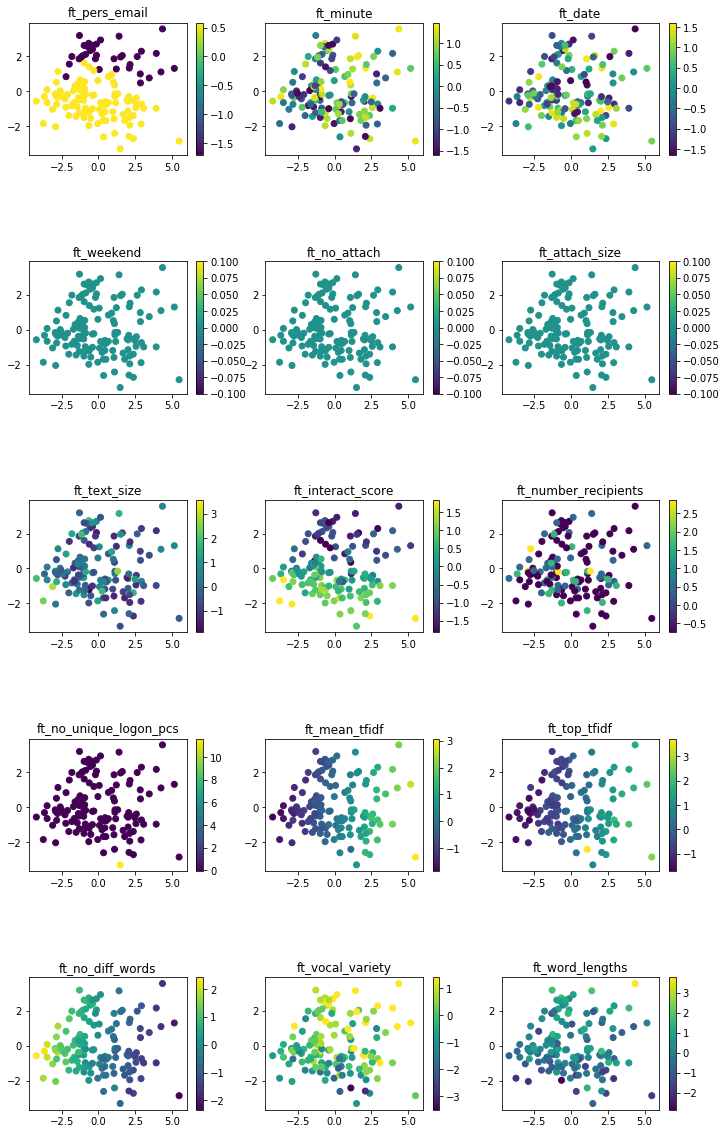

In [356]:
check_user(top_od_users[0])

# Outlier detection with KMeans clustering 

- For each user 
    - we cluster their emails into 2 clusters using KMeans
    - we compute some descriptive stats (distance between clusters, inertia, cluster sizes) about these clusters

In [267]:
# g = df.loc[users[0]]

# from sklearn.cluster import KMeans

# scaler = StandardScaler()
# g[COLS] = scaler.fit_transform(g[COLS])

# kmeans = KMeans(n_clusters=2, max_iter=10)
# kmeans = kmeans.fit(g[COLS])
# np.linalg.norm(kmeans.cluster_centers_[1] - kmeans.cluster_centers_[0])

In [296]:
counter = 0

def _cluster(g):
    global counter
    counter += 1
    if counter % 100 == 0:
        print(counter)
    
    scaler = StandardScaler()
    g[COLS] = scaler.fit_transform(g[COLS])

    kmeans = KMeans(n_clusters=2, max_iter=10)
    kmeans = kmeans.fit(g[COLS])
    cluster_dist = np.linalg.norm(kmeans.cluster_centers_[1] - kmeans.cluster_centers_[0])
    
    cl_sizes = pd.Series(kmeans.labels_).value_counts().sort_values().values
    
    inertia = kmeans.inertia_
    
    return pd.Series({
        'cldist': cluster_dist,
        'inertia': inertia,
        'smaller': cl_sizes[0],
        'bigger': cl_sizes[1],
    })
    

df_cluster = df.loc[users_enough_emails].groupby('user').apply(_cluster)
df_cluster.to_csv('user_cluster.csv')
df_cluster = pd.read_csv('user_cluster.csv')

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

100


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

200


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

300


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data wit

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

400


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

500


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

600


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

700


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data wit

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

800


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

900


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

1000


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

1100


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

1200


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

1300


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

1400


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

1500


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

1600


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

1700


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

1800


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

1900


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

2000


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data wit

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

2100


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

2200


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

2300


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

2400


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

2500


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

2600


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data wit

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data wit

2700


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

2800


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

2900


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

3000


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

3100


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

3200


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

3300


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

3400


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

3500


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

3600


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data wit

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

3700


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

3800


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

3900


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

4000


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

4100


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

4200


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

4300


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

4400


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data wit

4500


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

4600


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

4700


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data wit

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

4800


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

4900


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

5000


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

5100


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data wit

5200


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

5300


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

5400


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

5500


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

5600


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

5700


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

5800


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

5900


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

6000


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

6100


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWar

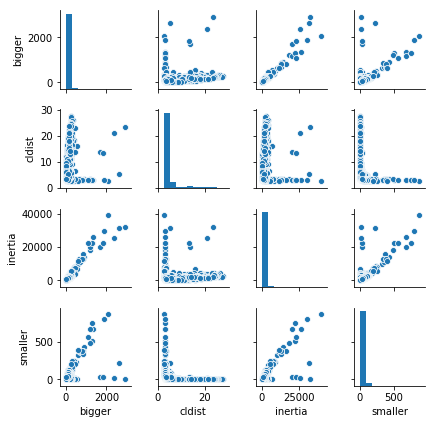

In [357]:
sns.pairplot(df_cluster, height=1.5)

### The most anomalous users according to the cluster size

In [359]:
# Sort by cluster size (descending)

most_weird = df_cluster.sort_values(by='cldist', ascending=False).head(100)
most_weird_users = most_weird.index

most_weird.head(100)

bigger     cldist       inertia  smaller
user                                             
CBG0490   268.0  27.692728   2463.963685      1.0
IMC0133   237.0  27.253560   2116.364298      1.0
GGM1604   339.0  26.297754   4410.462147      1.0
GCW0456   245.0  26.183860   2269.192453      1.0
DDM1065   273.0  26.092837   2609.648680      1.0
KCL0099   313.0  25.799211   3732.520476      1.0
JBD0616   250.0  25.422500   2368.271418      1.0
NGB1625   272.0  25.073280   3195.633463      1.0
RTO0313   247.0  24.891726   2358.900344      1.0
JOR1495   280.0  24.882898   3317.044792      1.0
YBD1929   254.0  24.494359   2462.379208      1.0
LCD0622   226.0  24.440474   2129.294674      1.0
WDS1286   258.0  24.386298   3033.604598      1.0
BHG1947   252.0  24.259397   2955.807836      1.0
UHM1273   238.0  24.213956   2762.137546      1.0
KJN0240   316.0  24.074008   4177.270390      1.0
TDC1086   251.0  24.026089   3205.037724      1.0
AKM0214   243.0  23.994185   2842.638619      1.0
HDD0789   233.0  23.959834   2236.379678      1.0
YJB0171   243.0  23.909556   3090.676016      1.0
JMW0038   240.0  23.880492   2324.088414      1.0
GJM1409   241.0  23.703465   2828.467464      1.0
ZBC0291   169.0  23.655711   1823.699037      1.0
REL1335   251.0  23.619576   2468.329471      1.0
LAH0463  2908.0  23.599221  31843.930420     11.0
QJH1605   282.0  23.586383   3407.648303      1.0
DDA0476   230.0  23.529068   2220.779565      1.0
ODB0034   239.0  23.427594   2813.434746      1.0
MAW1397   250.0  23.424196   2465.493079      1.0
BTD1059   272.0  23.410092   3275.975031      1.0
...         ...        ...           ...      ...
IIM0781   163.0  20.850099   1863.924138      1.0
CLL0494   162.0  20.822539   1525.081845      1.0
KAG0566   145.0  20.763405   1615.833874      1.0
NKT1510   236.0  20.762636   2888.731884      1.0
DTB0964   153.0  20.684675   1730.922521      1.0
CDD1124   194.0  20.677761   2499.622884      1.0
DJC0137   159.0  20.654315   1816.065532      1.0
MMG0943   140.0  20.627660   1269.517380      1.0
CKB0245   181.0  20.619899   2125.155925      1.0
IAR0301   170.0  20.598664   1972.176351      1.0
CWB0065   157.0  20.533064   1477.061694      1.0
ANR0502   164.0  20.461725   1893.855275      1.0
MYB0686   203.0  20.435114   2644.453157      1.0
NIM1203   144.0  20.414955   1616.103874      1.0
KPM1002   165.0  20.403680   1910.197745      1.0
CCC0569   152.0  20.384047   1729.206384      1.0
EXB0090   192.0  20.335883   1904.594598      1.0
HBW0057   185.0  20.312986   2193.600975      1.0
SOG0411   145.0  20.294351   1342.960277      1.0
NRR0476   139.0  20.270815   1552.029085      1.0
LHP0320   314.0  20.196685   3613.351200      2.0
NCU1166   153.0  20.189083   1443.047663      1.0
KJP0371   169.0  20.164093   1805.801076      1.0
RNC1295   251.0  20.141989   2737.014796      2.0
LJL1891   148.0  20.118445   1683.964640      1.0
TUJ1007   149.0  20.087177   1399.195281      1.0
BDH0981   160.0  20.068985   1853.737474      1.0
CJH0504   147.0  20.047125   1672.828246      1.0
OWC0518   153.0  20.018120   1757.877000      1.0
XDM0723   141.0  19.988012   1307.292891      1.0

[100 rows x 4 columns]

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


activity attachments  bcc  \
1486398     Send           5  NaN   
129562      Send           1  NaN   
291407      Send           0  NaN   
1304212     Send           1  NaN   
934884      Send           1  NaN   
429456      Send           0  NaN   
164293      Send           0  NaN   
708556      Send           0  NaN   
1453187     Send           1  NaN   
301262      Send           0  NaN   
1135647     Send           2  NaN   
493096      Send           2  NaN   
1161322     Send           0  NaN   
936220      Send           0  NaN   
817066      Send           1  NaN   
215114      Send           1  NaN   
1016194     Send           0  NaN   
1433744     Send           3  NaN   
246222      Send           0  NaN   
718407      Send           0  NaN   
1470819     Send           0  NaN   
746268      Send           3  NaN   
349946      Send           0  NaN   
1231000     Send           0  NaN   
570266      Send           1  NaN   
59249       Send           0  NaN   
273557      Send           0  NaN   
1043474     Send           1  NaN   
120213      Send           0  NaN   
954673      Send           0  NaN   
...          ...         ...  ...   
1343432     Send           9  NaN   
79781       Send           0  NaN   
1125610     Send           0  NaN   
583397      Send           0  NaN   
894212      Send           1  NaN   
747794      Send           0  NaN   
497118      Send           0  NaN   
34482       Send           0  NaN   
765028      Send           0  NaN   
410657      Send           2  NaN   
1392693     Send           0  NaN   
184906      Send           0  NaN   
1053649     Send           0  NaN   
232466      Send           2  NaN   
1158385     Send           0  NaN   
384298      Send           0  NaN   
1335566     Send           1  NaN   
1125861     Send           0  NaN   
598731      Send           2  NaN   
253485      Send           0  NaN   
1417888     Send           0  NaN   
984330      Send           0  NaN   
354903      Send           0  NaN   
1006007     Send           0  NaN   
1381012     Send           0  NaN   
790142      Send           2  NaN   
149690      Send           0  NaN   
857653      Send           0  NaN   
1453350     Send           0  NaN   
240017      Send           0  NaN   

                                                        cc  \
1486398                                                NaN   
129562   Kirby.Ruby.Lyons@dtaa.com;Iris.Rhea.Terrell@dt...   
291407                                                 NaN   
1304212                                                NaN   
934884   Bruce.Eden.Clemons@dtaa.com;Gabriel.B.Bolton@r...   
429456                                                 NaN   
164293                         Kimberley_Anderson@juno.com   
708556                       Gabriel.B.Bolton@raytheon.com   
1453187                                                NaN   
301262                                                 NaN   
1135647                                                NaN   
493096                                                 NaN   
1161322                                                NaN   
936220                                                 NaN   
817066                                                 NaN   
215114                         Maggy.Melissa.Burt@dtaa.com   
1016194   Douglas.Martin@cox.net;Lee_C_Cochran@netzero.com   
1433744                                                NaN   
246222                                                 NaN   
718407                                                 NaN   
1470819                                                NaN   
746268                      Orson.Barrett.Houston@dtaa.com   
349946                          Caleb.Jonas.Chang@dtaa.com   
1231000                                                NaN   
570266   Kirk.Palmer.Rosales@dtaa.com;Katell.Amethyst.T...   
59249                      Raphael.Benjamin.Bryan@dtaa.com   
273557                                 

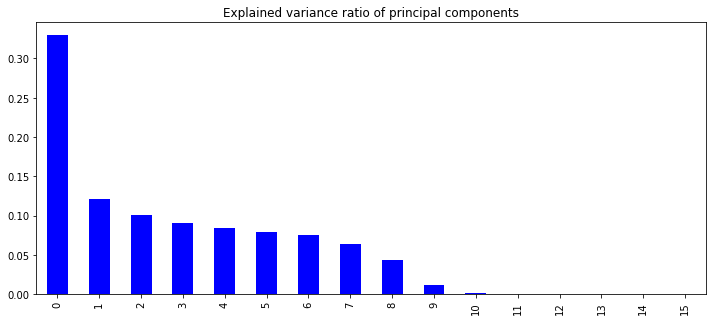

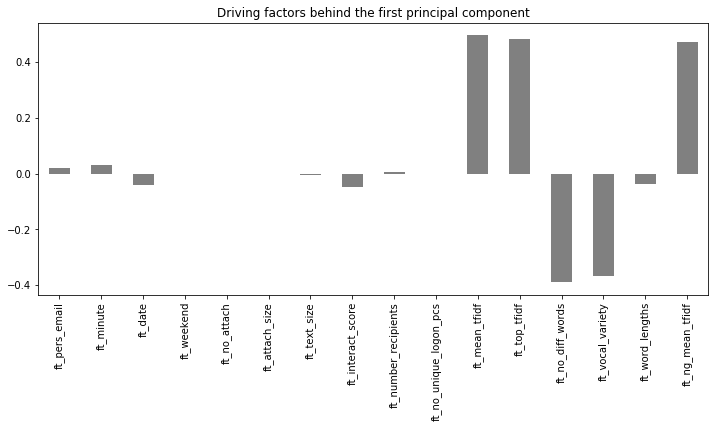

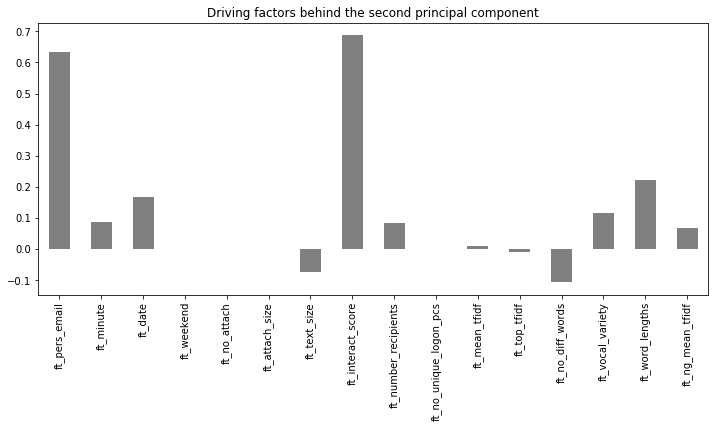

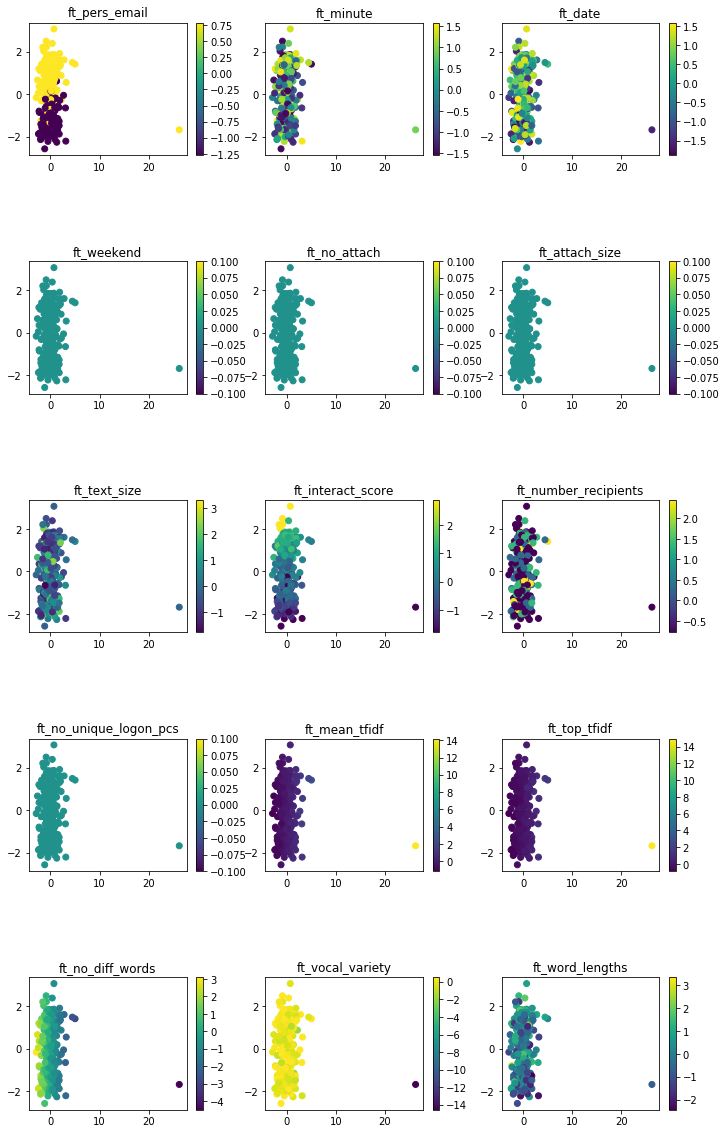

In [360]:
check_user('CBG0490')

activity attachments  bcc  \
407158      Send         NaN  NaN   
819711      Send         NaN  NaN   
629824      Send         NaN  NaN   
285303      Send         NaN  NaN   
1121338     Send         NaN  NaN   
1048571     Send         NaN  NaN   
599293      Send         NaN  NaN   
304430      Send         NaN  NaN   
713111      Send         NaN  NaN   
7970        Send         NaN  NaN   
438181      Send         NaN  NaN   
95038       Send         NaN  NaN   
1396875     Send         NaN  NaN   
834670      Send         NaN  NaN   
429808      Send         NaN  NaN   
1485406     Send         NaN  NaN   
451848      Send         NaN  NaN   
668082      Send         NaN  NaN   
1339542     Send         NaN  NaN   
109742      Send         NaN  NaN   
589224      Send         NaN  NaN   
3163        Send         NaN  NaN   
207370      Send         NaN  NaN   
1001983     Send         NaN  NaN   
552213      Send         NaN  NaN   
1308985     Send         NaN  NaN   
950320      Send         NaN  NaN   
201139      Send         NaN  NaN   
1443427     Send         NaN  NaN   
219919      Send         NaN  NaN   
...          ...         ...  ...   
545567      Send         NaN  NaN   
1237689     Send         NaN  NaN   
537863      Send         NaN  NaN   
936773      Send         NaN  NaN   
473506      Send         NaN  NaN   
477843      Send         NaN  NaN   
776385      Send         NaN  NaN   
287486      Send         NaN  NaN   
1316458     Send         NaN  NaN   
660546      Send         NaN  NaN   
407481      Send         NaN  NaN   
187022      Send         NaN  NaN   
292927      Send         NaN  NaN   
261609      Send         NaN  NaN   
271489      Send         NaN  NaN   
1035402     Send         NaN  NaN   
1371644     Send         NaN  NaN   
43024       Send         NaN  NaN   
930459      Send         NaN  NaN   
1450712     Send         NaN  NaN   
694691      Send         NaN  NaN   
826169      Send         NaN  NaN   
1144782     Send         NaN  NaN   
252146      Send         NaN  NaN   
419604      Send         NaN  NaN   
661572      Send         NaN  NaN   
421709      Send         NaN  NaN   
997527      Send         NaN  NaN   
872127      Send         NaN  NaN   
1202075     Send         NaN  NaN   

                                                        cc  \
407158                      Brenda.Paloma.Allison@dtaa.com   
819711                       Reese.Linus.Faulkner@dtaa.com   
629824                       Halee.Brynne.Walters@dtaa.com   
285303                                                 NaN   
1121338                                                NaN   
1048571  Brody.William.Wilkins@dtaa.com;Brenda.Paloma.A...   
599293                                                 NaN   
304430                                                 NaN   
713111                                                 NaN   
7970                      Courtney.Aurora.Padilla@dtaa.com   
438181   Brenda.Paloma.Allison@dtaa.com;Elijah.Russell....   
95038                                                  NaN   
1396875                     Hasad.Forrest.Mendoza@dtaa.com   
834670                                                 NaN   
429808                                                 NaN   
1485406                                                NaN   
451848   Juliet.Shannon.Aguilar@dtaa.com;Burton_Miller@...   
668082                                                 NaN   
1339542                                                NaN   
109742                                                 NaN   
589224                             Miriam_Witt@netzero.com   
3163                          Raja.Vladimir.Jones@dtaa.com   
207370                                                 NaN   
1001983                                                NaN   
552213                                 TKP46@sbcglobal.net   
1308985                                                NaN   
950320                                 

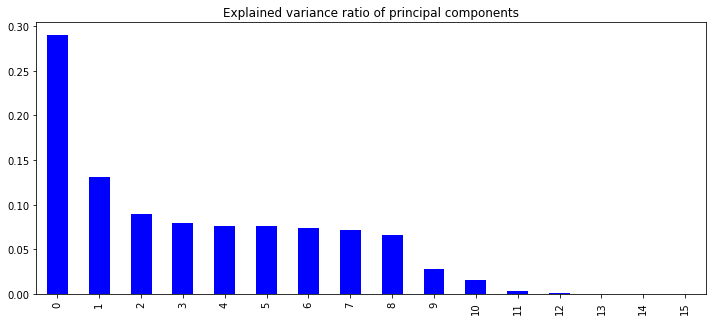

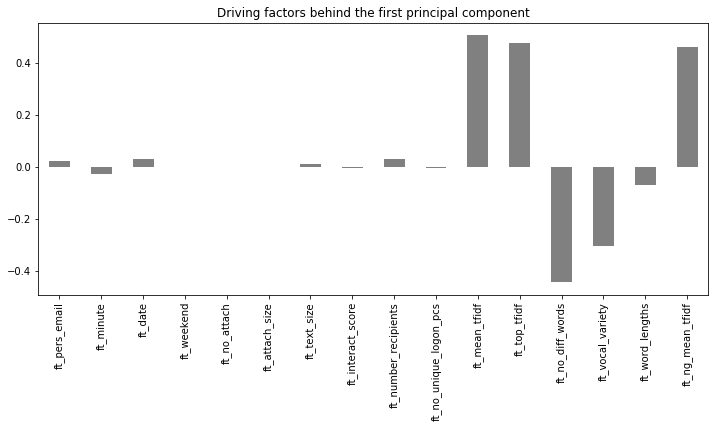

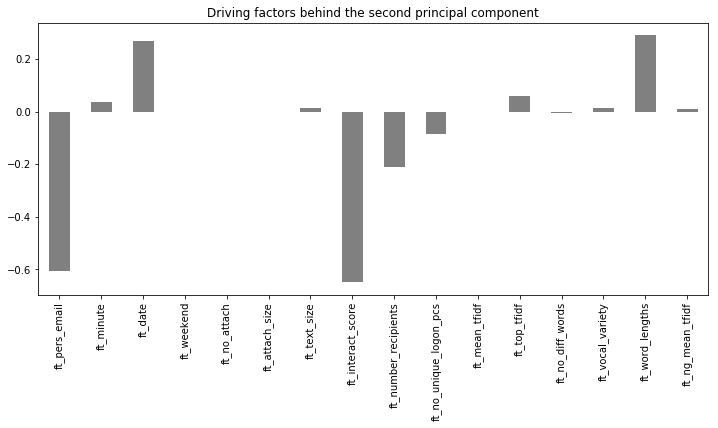

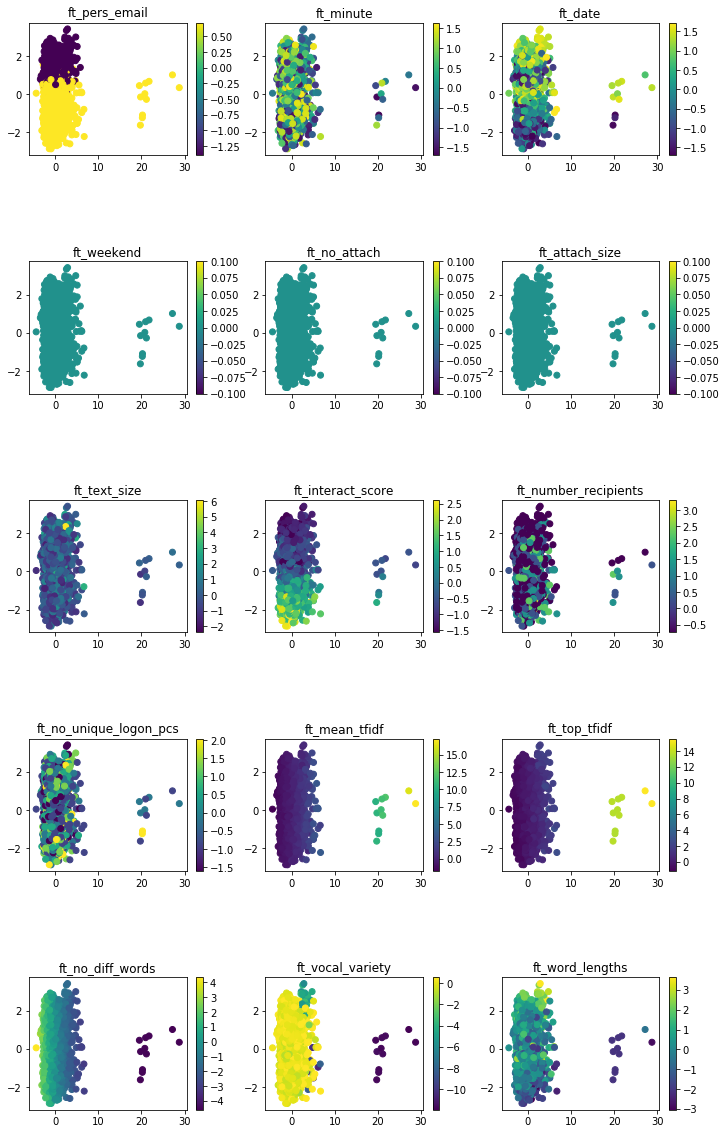

In [361]:
check_user('LAH0463')

# Where are the most anomalous records (according to KMeans) in the isolation forest outlier scores?

/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of highest outlier scores (by isolation forest)')

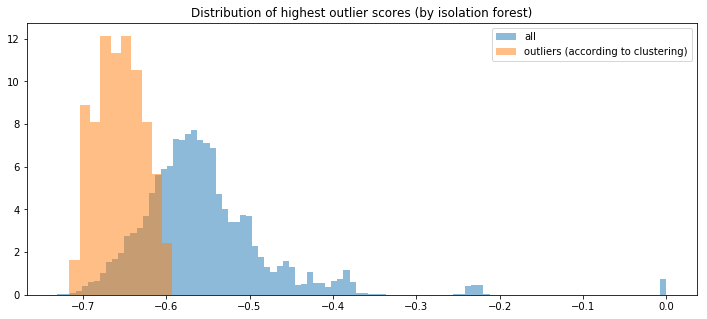

In [362]:
plt.figure(figsize=(12, 5))
plt.hist(df_dsc_user['min'], bins=100, alpha=0.5, normed=True, label='all')
plt.hist(df_dsc_user[df_dsc_user['user'].isin(most_weird_users)]['min'], alpha=0.5, normed=True, label='outliers (according to clustering)')
plt.legend()
plt.title('Distribution of highest outlier scores (by isolation forest)')

# Autoencoders (WIP)

In [311]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 5  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats


# this is our input placeholder
input_row = Input(shape=(len(COLS),))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_row)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(len(COLS), activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_row, decoded)

In [314]:
# this model maps an input to its encoded representation
encoder = Model(input_row, encoded)

In [315]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [316]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(df[COLS])

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# THANK YOU

In [327]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5545417499489168946
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281553818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11197504448040691840
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: ab6d:00:00.0, compute capability: 3.7"
]


In [326]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()


['/job:localhost/replica:0/task:0/device:GPU:0']

In [328]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_emails = encoder.predict(x_test)
decoded_emails = decoder.predict(encoded_emails)

In [329]:
encoded_emails

array([[5160.8916,    0.    ,    0.    , 4983.066 , 5943.2285],
       [3776.3484,    0.    ,    0.    , 3692.668 , 4296.242 ],
       [6003.9336,    0.    ,    0.    , 5723.436 , 7006.616 ],
       ...,
       [3903.5886,    0.    ,    0.    , 3895.362 , 4369.5723],
       [5396.8047,    0.    ,    0.    , 5117.2812, 6314.6924],
       [4151.088 ,    0.    ,    0.    , 4108.405 , 4723.631 ]],
      dtype=float32)

In [330]:
decoded_emails

array([[1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.]], dtype=float32)

In [331]:
x_test

ft_pers_email  ft_minute  ft_date  ft_weekend  ft_no_attach  \
user                                                                   
UAR0024              1        955       57           0             0   
EBC0390              1        890       70           0             1   
OQE0920              0        651      319           0             0   
TSB0614              0       1119      144           0             0   
RLT2120              1        801       96           0             0   
DBW0483              1        854      126           0             1   
EAC0410              1        519      236           0             0   
BAH0875              1        593      402           0             1   
NGF0157              1        449      322           0             1   
NIM1203              0        525      208           0             0   
YHO0982              0        700       99           0             2   
LDF0644              0        742      139           0             2   
AIM0627              1        482      369           0             1   
MAR3478              0        493      196           0             0   
HBB0056              1        815      255           0             1   
RDM0115              0        685      440           0             1   
EMS0497              0        514      437           0             0   
TAL1665              1        520        7           0             0   
ABN0239              0        554      348           0             1   
MDH0686              1       1095       45           1             1   
IAS1666              1       1011      352           0             0   
BWM0735              0        943      224           0             0   
LCF0962              1        528       85           0             0   
KDB1206              0        971      104           0             0   
YBD1929              0        955      504           0             0   
RFC1991              0       1079       73           0             0   
KCM0466              0        952       86           0             0   
ECM0519              1        650      378           0             2   
COM0321              1        749       37           0             1   
TMM0292              1        553      365           0             0   
...                ...        ...      ...         ...           ...   
JCR0172              1        937      266           0             1   
GTS0322              0        572      274           0             0   
CBG0183              1        945      231           0             0   
YDM1822              1        502      407           0             0   
CKH1151              0        899      238           0             0   
EZH2526              1        504      447           0             0   
TUB1442              0       1083      359           0             0   
GTD0116              1       1009      483           0             1   
MNC3904              1        610       21           0             0   
JEH1220              1        566      103           0             0   
JER0404              1        931      121           0             1   
KTH0436              0        707      446           0             0   
ORM0669              1        903      415           0             1   
MOW1888              0        484      253           0             0   
WKF0012              0        926      268           0             1   
ACW0078              1        791      378           0             0   
CRB0648              0        950      232           0             2   
AOC1283              1        609       44           0             1   
DAC3010              0       1000       26           0             0   
DKG1338              1        908      373           0             0   
KCC1988              1        740      497           0             0   
JMW0038              0        754      462           0             0   
RAC2950              1        746      102       